(400, 64, 64)
(400,)
(320,)
Эпоха  0
Train Loss:  3.7246928
Train Accuracy:  0.0
Validation Loss:  3.6961162
Validation Accuracy:  0.0
Эпоха  1
Train Loss:  3.6960728
Train Accuracy:  0.0
Validation Loss:  3.6706023
Validation Accuracy:  0.0
Эпоха  2
Train Loss:  3.670321
Train Accuracy:  0.0
Validation Loss:  3.6469789
Validation Accuracy:  0.0
Эпоха  3
Train Loss:  3.6464763
Train Accuracy:  0.0
Validation Loss:  3.623783
Validation Accuracy:  0.9875
Эпоха  4
Train Loss:  3.6230626
Train Accuracy:  0.996875
Validation Loss:  3.6001542
Validation Accuracy:  0.9875
Эпоха  5
Train Loss:  3.5992165
Train Accuracy:  0.996875
Validation Loss:  3.575109
Validation Accuracy:  0.9875
Эпоха  6
Train Loss:  3.573937
Train Accuracy:  0.996875
Validation Loss:  3.5487766
Validation Accuracy:  0.9875
Эпоха  7
Train Loss:  3.5473511
Train Accuracy:  0.996875
Validation Loss:  3.5203846
Validation Accuracy:  0.9875
Эпоха  8
Train Loss:  3.5186868
Train Accuracy:  0.996875
Validation Loss:  3.4890256

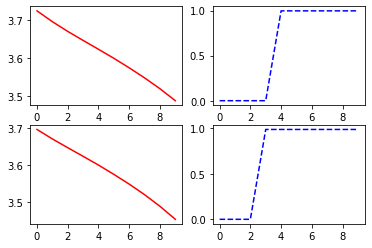

In [ ]:
import torch
import torch.nn.functional as F
from torch import autograd, nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils import data

from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()
train = np.load('olivetti_faces.npy') 
label = np.load("olivetti_faces_target.npy")
X = train
Y = label
print(X.shape)            
print(Y.shape)
train_rate = 0.8
X_train = np.zeros([int(train_rate * X.shape[0]),64,64], dtype=float)
Y_train = np.zeros([int(train_rate * X.shape[0])], dtype=int)

X_val = np.zeros([int((1-train_rate) * X.shape[0]+1),64,64], dtype=float)
Y_val = np.zeros([int((1-train_rate) * X.shape[0]+1)], dtype=int)


for i in range(X.shape[0]):
    ie=0
    iv=0
    if (i%10)/10 >= train_rate:
        X_train[ie] = X[i]
        Y_train[ie] = Y[i]
        ie += 1
    else:
        X_val[iv] = X[i]
        Y_val[iv] = Y[i]
        iv += 1

X_train = X_train.reshape(320, -1, 64, 64)
X_val = X_val.reshape(80, -1, 64, 64)

print(Y_train.shape)
X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(Y_train)

X_val = torch.Tensor(X_val)
Y_val = torch.Tensor(Y_val)  

batch_size = 20

train_loader = torch.utils.data.DataLoader(X_train, 
                                            batch_size=batch_size,
                                            )
val_loader = torch.utils.data.DataLoader(X_val, 
                                            batch_size=batch_size, 
                                            )

class CNNModule(nn.Module):
    def __init__(self):
        super(CNNModule, self).__init__()
        self.conv1 = nn.Conv2d(1, 80, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(80, 240, 5)
        self.fc1 = nn.Linear(240 * 13 * 13, 10140)
        self.fc2 = nn.Linear(10140, 512)
        self.fc3 = nn.Linear(512, 40)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 240 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def make_train(model,dataset,n_iters):
    X_train,Y_train,X_val,Y_val = dataset
    kriter = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    #Чекаем lossы and accuracy
    tl=np.zeros(n_iters) #train loss
    ta=np.zeros(n_iters) #train accuracy
    vl=np.zeros(n_iters) #validation loss
    va=np.zeros(n_iters) #validation accuracy

    Y_train = Y_train.long()
    Y_val = Y_val.long()

    for i in range(n_iters):  
        train_out = model.forward(X_train)
        train_loss = kriter(train_out,Y_train)
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_predict = train_out.cpu().detach().argmax(dim=1)
        train_accuracy = (train_predict.cpu().numpy()==Y_train.cpu().numpy()).mean() 
        val_out = model.forward(X_val)
        val_loss = kriter(val_out,Y_val)
        val_predict = val_out.cpu().detach().argmax(dim=1)
        val_accuracy = (val_predict.cpu().numpy()==Y_val.cpu().numpy()).mean()

        tl[i] = train_loss.cpu().detach().numpy()
        ta[i] = train_accuracy
        vl[i] = val_loss.cpu().detach().numpy()
        va[i] = val_accuracy

        print("Эпоха ", i)
        print("Train Loss: ", train_loss.cpu().detach().numpy())
        print("Train Accuracy: ", train_accuracy)
        print("Validation Loss: ", val_loss.cpu().detach().numpy())
        print("Validation Accuracy: ", val_accuracy)

    model = model.cpu()

    plt.subplot(2,2,1)
    plt.plot(np.arange(n_iters), tl, 'r-')
    plt.subplot(2,2,2)
    plt.plot(np.arange(n_iters), ta, 'b--')

    plt.subplot(2,2,3)
    plt.plot(np.arange(n_iters), vl, 'r-')
    plt.subplot(2,2,4)
    plt.plot(np.arange(n_iters), va, 'b--')    

dataset = X_train, Y_train, X_val, Y_val

model = CNNModule()
make_train(model, dataset, 10)

train/test подбирался на основе тестов, с учётом опыта работы с изображениями и CNN. Оптимальные значения 80/20